In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openxai.model import LoadModel
from openxai.dataloader import return_loaders
from captum.attr import Saliency

In [ ]:
def partial_dependence(f, xs, X, s):
    X_raw = X.copy()
    X_raw[:, s] = xs
    return f.predict_proba(X_raw)[:, 1].mean()

def conditional_dependence(f, xs, X, s):
    X_raw = X.copy()
    X_s = X_raw[:, s]
    epsilon = X_s.ptp() / 18
    X_cond = X_raw[(X_s > xs - epsilon) & (X_s < xs + epsilon), :]
    if X_cond.shape[0] == 0:
        return partial_dependence(f, xs, X, s)
    else:
        X_cond[:, s] = xs
        return f.predict_proba(X_cond)[:, 1].mean()

def dale(f, xs, X, s):
    explainer = Saliency(f)
    X_raw = X.copy()
    X_s = X_raw[:, s]
    x_smin = X_s.min()
    delta_x = X_s.ptp() / 18
    k = 0
    mu_k = 0
    while x_smin + k * delta_x < xs:
        S_k = (X_s > x_smin + k * delta_x) & (X_s < x_smin + (k+1) * delta_x)
        if np.any(S_k):
            X_k = X[S_k, :]
            inputs = torch.as_tensor(X_k, dtype=torch.float)
            inputs.requires_grad_()
            mu_k += explainer.attribute(inputs, target=1, abs=False)[:, s].mean().item()
        k += 1
    return delta_x * mu_k        

In [ ]:
def calculate_feature_effects(model, X):
    pd_dict = {}
    cd_dict = {}
    dale_dict = {}
    for s in range(X.shape[1]):
        X_s = X[:, s]
        if len(np.unique(X_s)) < 3:
            continue
        pd_dict[s] = []
        cd_dict[s] = []
        dale_dict[s] = []
        for xs in np.linspace(X_s.min(), X_s.max(), 18):
            pd_dict[s] += [partial_dependence(model, xs, X, s)]
            cd_dict[s] += [conditional_dependence(model, xs, X, s)]
            dale_dict[s] += [dale(model, xs, X, s)]
    return pd.DataFrame(pd_dict), pd.DataFrame(cd_dict), pd.DataFrame(dale_dict)

In [ ]:
results = pd.DataFrame({'dataset': [], 'sigma': [], 'seed': [], 'layer': [], 'dfe': [], 'performance': [], 'label': []})

model_name = 'ann'
for data_name in ['heloc', 'gaussian', 'pima', 'heart', 'adult', 'german']:
    _, loader_test = return_loaders(data_name=data_name, download=True, batch_size=128)
    X = loader_test.dataset.data
    y = loader_test.dataset.targets.to_numpy()
    model = LoadModel(data_name=data_name, ml_model=model_name, pretrained=True)
    model.eval()
    baseline = calculate_feature_effects(model, X)
    for sigma in [0.1, 0.25, 0.5, 1]:
        for seed in range(20):
            np.random.seed(seed)
            torch.manual_seed(seed)
            for i in reversed(range(len(model.network))):
                if isinstance(model.network[i], torch.nn.Linear):
                    with torch.no_grad():
                        # model.network[i] = torch.nn.Linear(model.network[i].weight.shape[1], model.network[i].weight.shape[0], bias=True)
                        model.network[i].weight.add_(torch.randn(model.network[i].weight.size()) * sigma)
                        model.network[i].bias.add_(torch.randn(model.network[i].bias.size()) * sigma)
                    predictions = (model.predict_proba(X)[:, 1] >= 0.5).astype(int)
                    pd_df, cd_df, dale_df = calculate_feature_effects(model, X)
                    results = pd.concat([results, pd.DataFrame({
                        'dataset': [data_name]*3,
                        'sigma': [sigma]*3,
                        'seed': [seed]*3,
                        'layer': [int(1+i/2)]*3,
                        'dfe': [np.abs(baseline[0]-pd_df).mean().mean(), np.abs(baseline[1]-cd_df).mean().mean(), np.abs(baseline[2]-dale_df).mean().mean()],
                        'performance': [(y == predictions).mean()]*3,
                        'label': ['marginal', 'conditional', 'accumulated']
                    })])
            model = LoadModel(data_name=data_name, ml_model=model_name, pretrained=True)

In [ ]:
results.to_csv("results/model_perturbation_full.csv", index=False)

In [2]:
results = pd.read_csv("results/model_perturbation_05.csv")

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

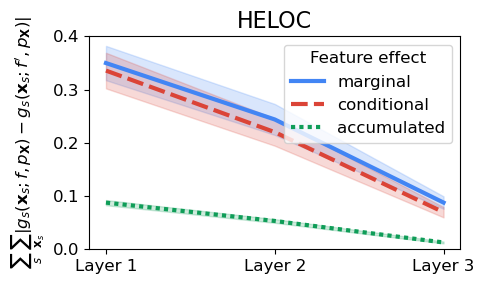

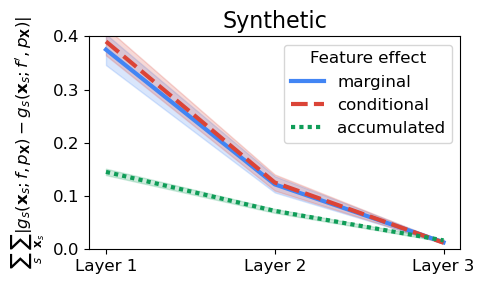

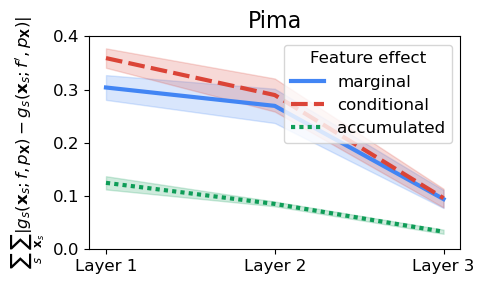

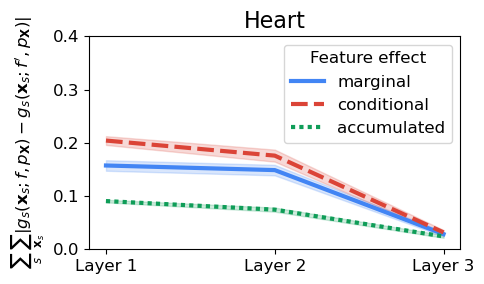

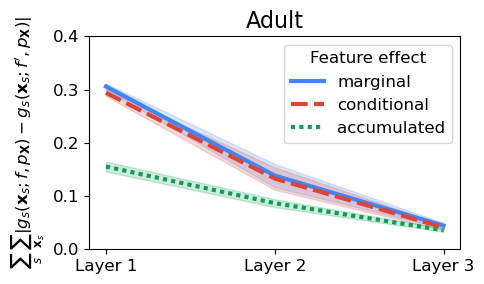

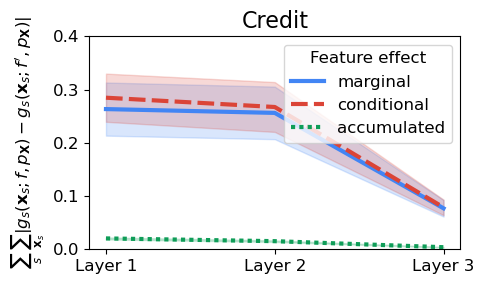

In [4]:
data_to_title = {"heloc": "HELOC", "gaussian": "Synthetic", "pima": "Pima", "heart": "Heart", 'adult': "Adult", 'german': "Credit"}
for data_name in ['heloc', 'gaussian', 'pima', 'heart', 'adult', 'german']:
    plt.figure(figsize=(5,3))
    g = sns.lineplot(
        data=results.loc[results.dataset == data_name,],
        x="layer", y="dfe",
        hue="label", style="label",
        errorbar="se",
        linewidth=3,
        palette=["#4285F4", "#DB4437", "#0F9D58"] # "#0F9D58", "#F4B400", "#4285F4", "#DB4437"
    )
    g.set_title(data_to_title[data_name], fontsize=BIGGER_SIZE)
    plt.legend(title="Feature effect")
    plt.xticks([1, 2, 3], ['Layer 1','Layer 2','Layer 3'])
    plt.xlabel(None)
    plt.ylabel("$\sum_s \; \sum_{\mathbf{x}_s} | g_s(\mathbf{x}_s; f, p_{\mathbf{X}}) - g_s(\mathbf{x}_s ; f', p_{\mathbf{X}}) |$", fontsize=SMALL_SIZE)
    plt.ylim([0, 0.4])
    plt.tight_layout()
    # plt.savefig(f'../figures/exp2_{data_name}.pdf')
    plt.show()